This notebook generates the figures for Chapter 4: Spatial Normalization from Poldrack, Mumford, and Nichols' _Handbook of fMRI Data Analysis (2nd Edition)_

In [42]:
import os,sys,glob
import numpy
import h5py
import scipy.stats
import scipy.interpolate
import matplotlib.pyplot as plt
import nilearn.plotting
%matplotlib inline
import nibabel
from nipype.interfaces import fsl

from nipype.caching import Memory
# use nipype's caching mechanism to save the results of the processing
mem = Memory(base_dir='.')

# set up rpy2 so we can use R magic
%load_ext rpy2.ipython

from fmrihandbook.utils.config import Config
from fmrihandbook.utils.run_shell_cmd import run_shell_cmd

from fmrihandbook.utils.show_image import showPDF


config=Config()



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


__Figure 4.1__: Use original manually generated version

In [2]:
showPDF(os.path.join(config.orig_figuredir,'Figure_4_1.pdf'))

https://web.stanford.edu/group/poldracklab/fmri-handbook-2e-data/figures-1e/Figure_4_1.pdf


__Figure 4.2__: Bias field correction

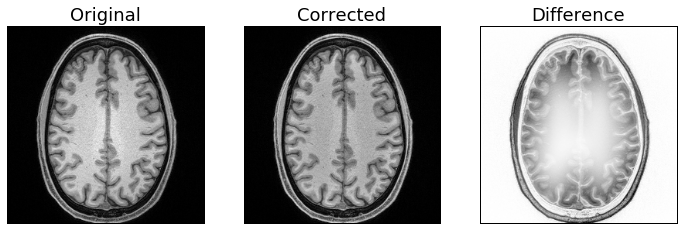

In [4]:
fig=plt.figure(figsize=(12,6))
orig=nibabel.load(config.data['ds031']['T1'])
origdata=orig.get_data()
bc=nibabel.load(config.data['ds031']['T1_bc'])
bc_data=bc.get_data()
diff=origdata - bc_data
diffimg=nibabel.Nifti1Image(diff,orig.get_affine(),orig.get_header())

cut_coord=180
ax1 = plt.subplot2grid((1,3), (0,0))
plt.xticks([])
plt.yticks([])
plt.title('Original',fontsize=18)
#nilearn.plotting.plot_anat(orig,display_mode='z',axes=ax1,
#                        cut_coords=[40],annotate=False)
ax1.imshow(numpy.rot90(origdata[:,:,cut_coord]),cmap='gray')
ax2 = plt.subplot2grid((1,3), (0,1))
ax2.imshow(numpy.rot90(bc_data[:,:,cut_coord]),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Corrected',fontsize=18)
#nilearn.plotting.plot_anat(bc,display_mode='z',axes=ax2,
#                        cut_coords=[40],annotate=False)

ax3 = plt.subplot2grid((1,3), (0,2))
p=ax3.imshow(numpy.rot90(diff[:,:,cut_coord]),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Difference',fontsize=18)
#nilearn.plotting.plot_anat(diffimg,display_mode='z',axes=ax3,
#                        cut_coords=[40],annotate=False)

plt.savefig(os.path.join(config.figuredir,'Figure_4_2.'+config.img_format),format=config.img_format,dpi=1200)



__Figure 4.3__: Use original manually generated version

In [6]:
showPDF(os.path.join(config.orig_figuredir,'Figure_4_3.pdf'))

https://web.stanford.edu/group/poldracklab/fmri-handbook-2e-data/figures-1e/Figure_4_3.pdf


__Figure 4.4__: Comparison of the results from linear and nonlinear registration, showing the differences in quality of registration across a group of 16 individuals.

In [7]:
showPDF(os.path.join(config.orig_figuredir,'Figure_4_4.pdf'))

https://web.stanford.edu/group/poldracklab/fmri-handbook-2e-data/figures-1e/Figure_4_4.pdf


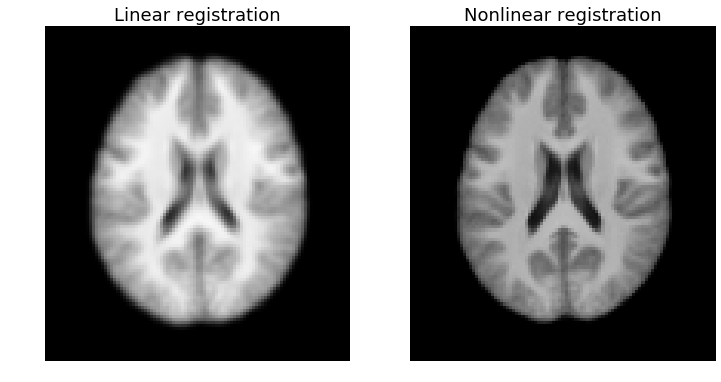

In [53]:
# take mean of linear and nonlinear images
fsl_merge = mem.cache(fsl.Merge)
anat_reg_linear=glob.glob(os.path.join(config.data['ds005']['datadir'],
                        'derivatives/affine/out_file/_subject_id_sub-*/sub-*_T1w_corrected_brain_flirt.nii.gz'))
anat_reg_linear.sort()

merge_results_linear=fsl_merge(in_files=anat_reg_linear,dimension='t')

fsl_meanimage=mem.cache(fsl.MeanImage)
meanimage_linear=fsl_meanimage(in_file=merge_results_linear.outputs.merged_file)

anat_reg_ants=glob.glob(os.path.join(config.data['ds005']['datadir'],
                        'derivatives/ants/warped_image/_subject_id_sub-*/transform_Warped.nii.gz'))
anat_reg_ants.sort()

merge_results_ants=fsl_merge(in_files=anat_reg_ants,dimension='t')

fsl_meanimage=mem.cache(fsl.MeanImage)
meanimage_ants=fsl_meanimage(in_file=merge_results_ants.outputs.merged_file)

fig=plt.figure(figsize=(12,6))
ax_linear = plt.subplot2grid((1,2), (0,0))
nilearn.plotting.plot_anat(meanimage_linear.outputs.out_file,
                           display_mode='z',cut_coords=[20],
                          axes=ax_linear,annotate=False)
plt.title('Linear registration',fontsize=18)
ax_ants = plt.subplot2grid((1,2), (0,1))

nilearn.plotting.plot_anat(meanimage_ants.outputs.out_file,
                           display_mode='z',cut_coords=[20],
                          axes=ax_ants,annotate=False)
plt.title('Nonlinear registration',fontsize=18)


plt.savefig(os.path.join(config.figuredir,'Figure_4_4.'+config.img_format),format=config.img_format,dpi=1200)



__Figure 4.5__: Warp fields

In [8]:
showPDF(os.path.join(config.orig_figuredir,'Figure_4_5.pdf'))

https://web.stanford.edu/group/poldracklab/fmri-handbook-2e-data/figures-1e/Figure_4_5.pdf


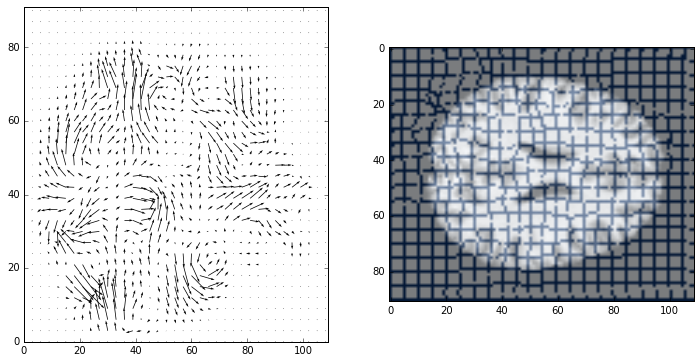

In [99]:
# first let's convert an ANTs warp field into nifti images using c3d
warpfile=os.path.join(config.data['ds005']['datadir'],
                    'derivatives/ants/composite_transform/_subject_id_sub-01/transformComposite.h5')
warpedfile=os.path.join(config.data['ds005']['datadir'],
                    'derivatives/ants/warped_image/_subject_id_sub-01/transform_Warped.nii.gz')
warpedimg=nibabel.load(warpedfile).get_data()

warphdf=h5py.File(warpfile)
warp=numpy.array(warphdf['/']['TransformGroup']['5']['TranformParameters']).reshape((91,109,91,3))
slicenum=48
warpslice=warp[:,:,slicenum,0:2]
X,Y = numpy.meshgrid(range(warpslice.shape[1]),range(warpslice.shape[0]))  

fig=plt.figure(figsize=(12,6))
ax = plt.subplot2grid((1,2), (0,0))

ax.quiver(X[::3, ::3],Y[::3, ::3],warpslice[...,0][::3, ::3],warpslice[...,1][::3, ::3], 
          color='black')
ax.axis([0,109,0,91])

# TBD: create warped grid - hoping that the ANTs tool starts working so I don't have 
# to do it by hand

grid=numpy.ones(warpslice.shape[:2])
for i in range(0,91,5):
    grid[i,:]=0
for j in range(0,109,5):
    grid[:,j]=0

ax = plt.subplot2grid((1,2), (0,1))


warpedgrid=numpy.zeros(grid.shape)
gridspots=numpy.where(grid<1)
gridwarp=warpslice[gridspots]

newgridspots=(numpy.zeros(gridspots[0].shape).astype('int'),numpy.zeros(gridspots[1].shape).astype('int'))
for i in range(len(gridspots[0])):
    x=gridspots[0][i]
    y=gridspots[1][i]
    newgridspots[0][i]=x+warpslice[x,y,0]
    newgridspots[1][i]=y+warpslice[x,y,1]

    
    

warpedgrid[newgridspots]=1
ax.imshow(warpedimg[:,:,slicenum],cmap='gray')
#ax.contour(warpedgrid,levels=[.5])
plt.imshow(warpedgrid,alpha=0.5,cmap='Blues')

__Figure 4.6__: Examples of cortical surfaces. Use original manual image.

In [9]:
showPDF(os.path.join(config.orig_figuredir,'Figure_4_6.pdf'))

https://web.stanford.edu/group/poldracklab/fmri-handbook-2e-data/figures-1e/Figure_4_6.pdf


__Figure 4.7__: Activation maps obtained using linear registration (12-parameter affine) and nonlinear registration (using ANTs). Regions showing activation in both analyses are shown in green. Those showing activation in nonlinear but not linear are shown in red, and those showing activation in linear but not nonlinear are shown in blue.

In [10]:
showPDF(os.path.join(config.orig_figuredir,'Figure_4_7.pdf'))

https://web.stanford.edu/group/poldracklab/fmri-handbook-2e-data/figures-1e/Figure_4_7.pdf


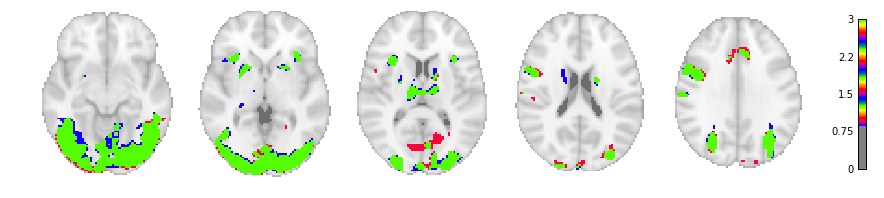

In [2]:
fwhm=4
cope=1
linear_stats=nibabel.load(os.path.join(config.data['ds005']['datadir'],
            'derivatives/randomise/_copenum_%d/_regtype_affine/_fwhm_%d/randomise__tfce_corrp_tstat1.nii.gz'%(cope,fwhm)))
ants_stats=nibabel.load(os.path.join(config.data['ds005']['datadir'],
            'derivatives/randomise/_copenum_%d/_regtype_ants/_fwhm_%d/randomise__tfce_corrp_tstat1.nii.gz'%(cope,fwhm)))

diff_data=numpy.zeros(linear_stats.get_data().shape)
ants_win=numpy.where((ants_stats.get_data()>0.95) & (linear_stats.get_data()<0.95))
linear_win=numpy.where((ants_stats.get_data()<0.95) & (linear_stats.get_data()>0.95))
conjunction=numpy.where((ants_stats.get_data()>0.95) & (linear_stats.get_data()>0.95))
diff_data[ants_win]=1
diff_data[linear_win]=2.
diff_data[conjunction]=3
diff_image=nibabel.Nifti1Image(diff_data,affine=linear_stats.get_affine())
nilearn.plotting.plot_stat_map(diff_image,threshold=0.9,
                                  display_mode='z',
                                  cut_coords=[-10,0,10,20,30],
                                   cmap='prism',
                                  colorbar=True,annotate=False,
                                  interpolation='nearest')
plt.savefig(os.path.join(config.figuredir,'Figure_4_7.'+config.img_format),format=config.img_format,dpi=1200)



__Figure 4.8__: QA for normalization.  Contours for one image are overlaid on the second image.  Top row shows contours for registered image overlaid onto template for linear (A) and nonlinear (B) registration.  Bottom row shows contours for template overlaid onto registered images for linear (C) and nonlinear (D) registration.

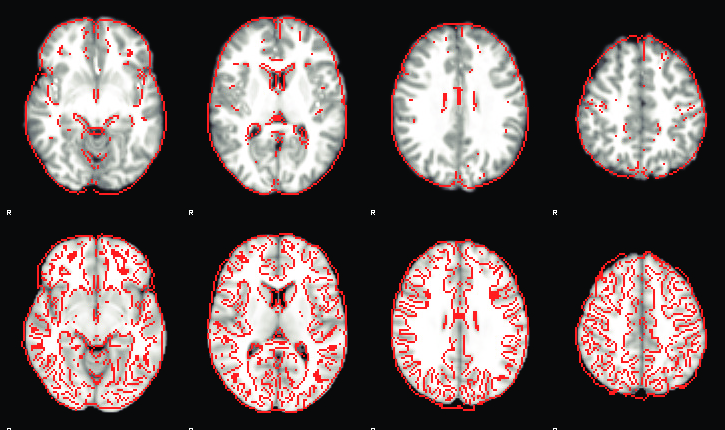

In [11]:
showPDF(os.path.join(config.orig_figuredir,'Figure_4_8.pdf'))

NameError: name 'anat_reg_linear' is not defined

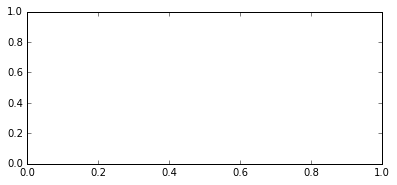

In [3]:
# compare registered image to template
fig=plt.figure(figsize=(14,6))
ax={}
z_slice = range(-20,35,20)
template_level=6000
template=os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz')
templatedata=nibabel.load(template).get_data()

# first show linear
ax[0]= plt.subplot2grid((2,2), (0,0))
anatdata_linear=nibabel.load(anat_reg_linear[0]).get_data()
anat_half_intensity=numpy.max(anatdata_linear.ravel())/2.
display = nilearn.plotting.plot_anat(template, display_mode='z', 
                            annotate=False,cut_coords=z_slice,
                            axes=ax[0],title='A')
display.add_contours(anat_reg_linear[0], contours=1, antialiased=False,
                     linewidths=0.5, levels=[anat_half_intensity], colors=['red'])

ax[1]= plt.subplot2grid((2,2), (1,0))
display2 = nilearn.plotting.plot_anat(anat_reg_linear[0], display_mode='z', 
                            annotate=False,cut_coords=z_slice,
                            axes=ax[1],title='C')
display2.add_contours(template, contours=1, antialiased=False,
                     linewidths=0.5, levels=[template_level], colors=['red'])

# then show ANTs
ax[2]= plt.subplot2grid((2,2), (0,1))
anatdata_ants=nibabel.load(anat_reg_ants[0]).get_data()
anat_half_intensity=225
display3 = nilearn.plotting.plot_anat(template, display_mode='z', 
                            annotate=False,cut_coords=z_slice,
                            axes=ax[2],title='B')
display3.add_contours(anat_reg_ants[0], contours=1, antialiased=False,
                     linewidths=0.5, levels=[anat_half_intensity], colors=['red'])
ax[3]= plt.subplot2grid((2,2), (1,1))
display4 = nilearn.plotting.plot_anat(anat_reg_ants[0], display_mode='z', 
                            annotate=False,cut_coords=z_slice,
                            axes=ax[3],title='D')
display4.add_contours(template, contours=1, antialiased=False,
                     linewidths=0.5, levels=[template_level], colors=['red'])

plt.savefig(os.path.join(config.figuredir,'Figure_4_8.'+config.img_format),format=config.img_format,dpi=1200)



__Figure 4.9__: Example of failed registration of a T1-weighted whole-head image with inaccurate header orientation information to a brain-extracted template.

In [13]:
showPDF(os.path.join(config.orig_figuredir,'Figure_4_9.pdf'))

https://web.stanford.edu/group/poldracklab/fmri-handbook-2e-data/figures-1e/Figure_4_9.pdf


In [89]:
# first we need to make an image file that has an incorrect qform

flipfile=os.path.join(config.data['ds031']['datadir'],'sub-01/ses-018/anat/T1_flipped.nii.gz')
swapdim=mem.cache(fsl.SwapDimensions)
swapdim(in_file=config.data['ds031']['T1'],out_file=flipfile,new_dims=('x','y','-z'))
flipimg=nibabel.load(flipfile)
flipimg.set_qform(numpy.diag([0.8,-0.8,0.8,0]))
flipimg.set_sform(numpy.diag([0.8,-0.8,0.8,0]))
flipimg.to_filename(flipfile)




out_file = /Users/poldrack/code/fmri-handbook-2e-code/notebooks/Chapter4-SpatialNormalization/nipype_mem/nipype-interfaces-fsl-preprocess-FLIRT/1294ff4500fc6acc39c46390490576d5/T1_flipped_flirt.nii.gz
out_log = /Users/poldrack/code/fmri-handbook-2e-code/notebooks/Chapter4-SpatialNormalization/nipype_mem/nipype-interfaces-fsl-preprocess-FLIRT/1294ff4500fc6acc39c46390490576d5/T1_flipped_flirt.log
out_matrix_file = /Users/poldrack/code/fmri-handbook-2e-code/notebooks/Chapter4-SpatialNormalization/nipype_mem/nipype-interfaces-fsl-preprocess-FLIRT/1294ff4500fc6acc39c46390490576d5/T1_flipped_flirt.mat



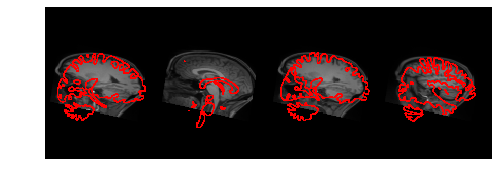

In [91]:

badflirt=mem.cache(fsl.FLIRT)
badflirt_results=badflirt(in_file=flipfile,
                          uses_qform=False,reference=template)
print(badflirt_results.outputs)


fig=plt.figure(figsize=(8,6))
ax={}
z_slice = range(-20,55,20)
template_level=6000

# first show linear
ax[0]= plt.subplot2grid((2,1), (0,0))
display1=nilearn.plotting.plot_anat(badflirt_results.outputs.out_file, display_mode='x', 
                            annotate=False,cut_coords=z_slice,axes=ax[0])
display1.add_contours(template, contours=1, antialiased=False,
                     linewidths=0.5, levels=[template_level], colors=['red'])

plt.savefig(os.path.join(config.figuredir,'Figure_4_9.'+config.img_format),format=config.img_format,dpi=1200)



__Figure 4.10__: Use original manual example

In [12]:
showPDF(os.path.join(config.orig_figuredir,'Figure_4_10.pdf'))

https://web.stanford.edu/group/poldracklab/fmri-handbook-2e-data/figures-1e/Figure_4_10.pdf


__Figure 4.11__: Registration of lesioned brain using cost function masking - use original image.

In [11]:
showPDF(os.path.join(config.orig_figuredir,'Figure_4_11.pdf'))

https://web.stanford.edu/group/poldracklab/fmri-handbook-2e-data/figures-1e/Figure_4_11.pdf
